<a href="https://colab.research.google.com/github/VladimirLinevich/py/blob/master/ML7_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving _train_sem09 (1).csv to _train_sem09 (1).csv
User uploaded file "_train_sem09 (1).csv" with length 18623278 bytes


In [7]:
data = pd.read_csv('_train_sem09 (1).csv')

# Разделим выборку на тренировочную и тестовую
y = data['Activity']
X = data.drop(columns='Activity')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Обучим модель логистической регрессии на всех признаках, 
# с параметрами по-умолчанию, чтобы перед глазами был некий эталон для сравнения

lr_full = linear_model.LogisticRegression(max_iter=1000, random_state=42)
lr_full.fit(X_train, y_train)

# Сделаем предсказание на тестовой выборке
y_test_pred = lr_full.predict(X_test)

# Метрики модели
print(metrics.classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70       318
           1       0.78      0.80      0.79       433

    accuracy                           0.75       751
   macro avg       0.75      0.75      0.75       751
weighted avg       0.75      0.75      0.75       751



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_

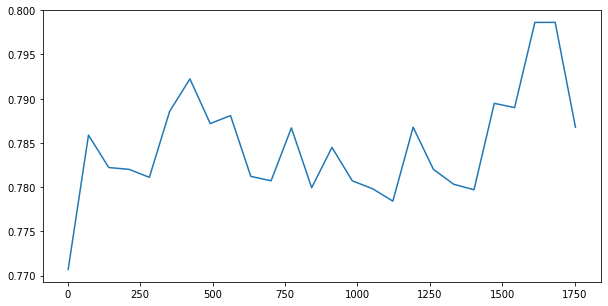

In [9]:
# ----- LogisticRegression и KBest
# Так как признаков много, запустим в цикле выбор разного количества признаков
# с помощью алгоритма KBest и проверим влияние количества признаков на целевую метрику

nFeatures_f1 = pd.DataFrame(columns=['i','f1'])
for i in range(2,data.shape[1]-1,70):
    selector = SelectKBest(f_regression, k=i)
    selector.fit(X_train, y_train)
    KBest_columns = list(selector.get_feature_names_out())

    lr = linear_model.LogisticRegression(max_iter=700, random_state=42)
    lr.fit(X_train[KBest_columns], y_train)

    # Сделаем предсказание на тестовой выборке
    y_test_pred = lr.predict(X_test[KBest_columns])
    nFeatures_f1.loc[i,'f1'] = metrics.f1_score(y_test, y_test_pred)
    nFeatures_f1.loc[i,'i'] = i

fig, ax = plt.subplots(figsize=(10, 5)) 
#Строим график зависимости f1 от количества признаков
ax.plot(nFeatures_f1['i'], nFeatures_f1['f1'])


Выводы: F1-score показывает интересную зависимость от количества признаков - начиная со 100 признаков, выбранных KBest, колеблется вокруг 0.785, и только к 1600 признакам вырастает всего на 0.01. Можно предположить, что будет достаточно оставить 200-400 признаков, чтобы не перегружать модель.

In [ ]:
# ----- LogisticRegression и GridSearchCV
# # Оптимизация параметров Логистической регрессии методом GridSearchCV с кросс-валидацией на 5 фолдов 

param_grid = {'penalty': ['l1', 'l2'] , # тип регуляризации
              'solver': ['saga','liblinear'], # алгоритм оптимизации
              'max_iter': [200,400],
              'class_weight': ['balanced'],
              'C': [0.01, 0.1, 0.3]
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

grid_search.fit(X_train, y_train)
print(metrics.classification_report(y_test, y_test_pred))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

In [ ]:
# ----- LogisticRegression и RandomizedSearchCV
# Подбор гиперпараметров логистической регрессии алгоритмом RandomizedSearchCV

param_distributions = { 'penalty': ['l1', 'l2'],
                        'solver': ['saga', 'liblinear'],
                        'max_iter': [200,400],
                        'class_weight': ['balanced'],
                        'C': [0.01, 0.1, 0.3]
                        }
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10,
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print(metrics.classification_report(y_test,y_test_pred))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

Wall time: 1min 45s
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       318
           1       0.79      0.79      0.79       433

    accuracy                           0.76       751
   macro avg       0.75      0.75      0.75       751
weighted avg       0.76      0.76      0.76       751

Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'class_weight': 'balanced', 'C': 0.1}


C:\Users\1\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# ----- LogisticRegression и Hyperopt
# Подбор гиперпараметров логистической регрессии алгоритмом Hyperopt

# зададим пространство поиска гиперпараметров
penalty_list = ['l1', 'l2']
solver_list = ['saga', 'liblinear']
space={'penalty': hp.choice('penalty', penalty_list),
        'solver': hp.choice('solver', solver_list),
        'max_iter': hp.quniform('max_iter', 200,700,100),
        'C': hp.quniform('C', 0.01, 0.52, 0.1)
      }
# Функция, которую будет минимизировать Hyperopt
def hyperopt_rf(params, cv=3, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': str(params['penalty']), 
              'solver': str(params['solver']), 
             'max_iter': int(params['max_iter']),
             'C': float(params['C'])
              }
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, class_weight = 'balanced', random_state=42)

    # обучаем модель
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

trials = Trials() # используется для логирования результатов
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          max_evals=3, # максимальное количество итераций
          trials=trials # логирование результатов
         )
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=42, 
    penalty = penalty_list[best['penalty']], 
    solver = solver_list[best['solver']], 
    max_iter = int(best['max_iter']),
    class_weight = 'balanced',
    C = float(best['C'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

print ('Метрики на обучающем наборе:')
print(metrics.classification_report(y_train,y_train_pred))
y_test_pred = model.predict(X_test)
print ('Метрики на тестовом наборе:')
print(metrics.classification_report(y_test,y_test_pred))

TPE is being used as the default algorithm.


100%|██████████| 3/3 [00:55<00:00, 18.41s/trial, best loss: -0.7711669655839183]
Наилучшие значения гиперпараметров {'C': 0.2, 'max_iter': 400.0, 'penalty': 0, 'solver': 0}
Метрики на обучающем наборе:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1399
           1       0.81      0.82      0.82      1601

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000

Метрики на тестовом наборе:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       318
           1       0.80      0.79      0.79       433

    accuracy                           0.76       751
   macro avg       0.76      0.76      0.76       751
weighted avg       0.76      0.76      0.76       751



C:\Users\1\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# -------- Случайный лес и RandomizedSearchCV
# Подбор гиперпараметров Случайного леса алгоритмом RandomizedSearchCV


param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [10,20,50],
              'max_depth': [5,10,15,20,25]
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)

%time random_search_forest.fit(X_train, y_train) 
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

y_test_pred = random_search_forest.predict(X_test)
print('Метрики на тестовом наборе:')
print(metrics.classification_report(y_test,y_test_pred))


Wall time: 13.7 s
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 10, 'max_depth': 10}
Метрики на тестовом наборе:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       318
           1       0.83      0.81      0.82       433

    accuracy                           0.79       751
   macro avg       0.79      0.79      0.79       751
weighted avg       0.79      0.79      0.79       751



In [ ]:
# -------- Случайный лес и Optuna
# Подбор гиперпараметров Случайного леса алгоритмом Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 220, 30)
  max_depth = trial.suggest_int('max_depth', 5, 25, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 50, 10)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=5)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('Метрики на обучающем наборе:')
print(metrics.classification_report(y_train,y_train_pred))

y_test_pred = model.predict(X_test)
print('Метрики на тестовом наборе:')
print(metrics.classification_report(y_test,y_test_pred))


[I 2022-09-05 14:01:28,762] A new study created in memory with name: RandomForestClassifier
[I 2022-09-05 14:01:30,701] Trial 0 finished with value: 0.7869674185463659 and parameters: {'n_estimators': 220, 'max_depth': 10, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.7869674185463659.
[I 2022-09-05 14:01:31,939] Trial 1 finished with value: 0.8176691729323308 and parameters: {'n_estimators': 130, 'max_depth': 10, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.8176691729323308.
[I 2022-09-05 14:01:33,285] Trial 2 finished with value: 0.7847533632286995 and parameters: {'n_estimators': 190, 'max_depth': 5, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8176691729323308.
[I 2022-09-05 14:01:35,025] Trial 3 finished with value: 0.8917910447761194 and parameters: {'n_estimators': 130, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8917910447761194.
[I 2022-09-05 14:01:36,419] Trial 4 finished with value: 0.8038908064010041 and parameters: {

Наилучшие значения гиперпараметров {'n_estimators': 130, 'max_depth': 15, 'min_samples_leaf': 10}
Метрики на обучающем наборе:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1399
           1       0.89      0.90      0.89      1601

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000

Метрики на тестовом наборе:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       318
           1       0.83      0.81      0.82       433

    accuracy                           0.80       751
   macro avg       0.79      0.79      0.79       751
weighted avg       0.80      0.80      0.80       751

